# Final project: The Battle of Neighborhoods

## Table of contents
* [Introduction: Problem Statement](#introduction)
* [Data and Methodology](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)

# Introduction: Problem Statement <a name="introduction"></a>

The purpose of this project is to determine the best type and the best location for a new restaurant in Austin, Texas. 

Accorsing to the Zagat <a href="https://www.zagat.com/b/30-most-exciting-food-cities-in-america-2017">"30 Most Exciting Food Cities in America 2017" </a> list, Austin is #2 destination in the US when it comes to food. In addition, Austin is one of <a href="https://www.forbes.com/sites/samanthasharf/2018/02/28/full-list-americas-fastest-growing-cities-2018/#3239a1d57feb">the America's most rapidly growing cities </a>. This makes it a very attractive place for the new businesses, including restaurants. 

There are several types of food that Austin is famous of, including, for instance, BBQ and mexican cuisine. In order to not get unnoticed when opening a new restaurant and to avoid competition with the well-known places, by the end of this project, we will suggest __the best location and the best unusual category for a new restaurant__.

# Data and Methodology <a name="data"></a>

We will use two types of data for this project: 
- information about Austin neighborhoods, including geographical coordinates, area and population,
- information about Austin restaurants, e.g., vanues, grouped by categories and neighborhoods, ratings and likes.

To acquire the data, three sources will be used:
- <a href = "http://www.city-data.com">City-Data</a> website, that contains information about neighborhoods of Austin,
- <a href = "http://austintx.areaconnect.com/zip2.htm?city=Austin&qs=TX&searchtype=bycity"> areaConnect </a> website, that will be use to get geographical coordinates based on the zipcode,
- Foursquare API .

The approach is based on the analysis of restaurant types, already availble in Austin. We focus on the most unusual categories(more specifically, 20 least represented type) and pick the best category based on the ratings and amount of likes for the unusual restaurants. As we don't want to overcrowd the neighborhood in which "the best category" is already presented, we further proceed by clustering the neighborhoods of Austin in order to determine similar neighborhoods and finally choose the best location.

# Data and Methodology <a name="analysis"></a>

## 1. Preparing the neighborhoods data for the analysis

In [1440]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# data scraping and handling JSON files
from bs4 import BeautifulSoup
import requests
import json
from pandas.io.json import json_normalize

To collect the neighborhoods data, we will use City-Data website, http://www.city-data.com. We start by parsing the particular webpage that contains general information about Austin neighborhoods.

In [1441]:
url = 'http://www.city-data.com/nbmaps/neigh-Austin-Texas.html#N22'
page = requests.get(url)

# Parse the content with BeautifulSoup
soup = BeautifulSoup(page.text, 'html.parser')
values = soup.findAll("div", {"class": "neighborhood"})

The webpage, that we just parsed, contains links to the pages with more infomation about each neighborhood. We visit each such webpage and collect for each of the neighborhoods the following information :
- neighborhood name,
- population,
- area (in sq miles),
- zipcode.

In [1442]:
population = []
area = []
zip_code = []
neighborhoods = []

# Population is not available for some neighborhoods,
# so we will store the corresponding names and append
# np.nan values
vals = []

# function to collect all the information for one neighborhood
def parse_a_neighborhood(soup):
    name = soup.find("div", {"class": "hgraph"})
    name = str(name)
    name = name.split("<td><b>")[1]
    name = name.split(":</b>")[0]
    neighborhoods.append(name)
    
    strng = soup.findAll("div", {"class": "content-item"})
    pop_l1 = len(population)
    for s in strng:
        s = str(s)
        if "Area" in s:
            s1 = s.split("Area:</b>")[1]
            s1 = s1.split("<b>square miles")[0]
            area.append(s1)
        if "Population" in s:
            s1 = s.split("Population:</b>")[1]
            s1 = s1.split("<br/><br/>")[0]
            population.append(s1)
        if "Zip codes" in s:
            s1 = s.split(".html\">")[1]
            s1 = s1.split("</a>.<br/>")[0]
            zip_code.append(s1)
     
    if(len(population)==pop_l1):
        vals.append(strng)
        population.append(np.nan)

In [1443]:
# get info about each neighborhood
link_for_neighs = "http://www.city-data.com/neighborhood/"
for value in values:
    value = str(value)

    value = value.split("neighborhood/")[1]
    value = value.split("\">")[0]

    link = link_for_neighs + value
    print(link)
    page = requests.get(link)
    soup = BeautifulSoup(page.text, 'html.parser')
    parse_a_neighborhood(soup)
# Check that all lists have the same length
print(len(population))
print(len(area))
print(len(zip_code))
print(len(neighborhoods))

http://www.city-data.com/neighborhood/2nd-Street-Disrict-Austin-TX.html
http://www.city-data.com/neighborhood/6th-Street-Disrict-Austin-TX.html
http://www.city-data.com/neighborhood/6th-Street-District-Austin-TX.html
http://www.city-data.com/neighborhood/Alamo-Park-Austin-TX.html
http://www.city-data.com/neighborhood/Allandale-Austin-TX.html
http://www.city-data.com/neighborhood/Arts-District-Austin-TX.html
http://www.city-data.com/neighborhood/Auditorium-Shores-Austin-TX.html
http://www.city-data.com/neighborhood/Barrington-Oaks-Austin-TX.html
http://www.city-data.com/neighborhood/Barton-Hills-Austin-TX.html
http://www.city-data.com/neighborhood/Barton-Springs-Austin-TX.html
http://www.city-data.com/neighborhood/Battle-Bend-Springs-Austin-TX.html
http://www.city-data.com/neighborhood/Blackland-Austin-TX.html
http://www.city-data.com/neighborhood/Bouldin-Creek-Austin-TX.html
http://www.city-data.com/neighborhood/Bratton-Austin-TX.html
http://www.city-data.com/neighborhood/Bratton-Lane-

http://www.city-data.com/neighborhood/University-Hills-Austin-TX.html
http://www.city-data.com/neighborhood/University-of-Texas-Austin-TX.html
http://www.city-data.com/neighborhood/University-of-Texas-at-Austin-Austin-TX.html
http://www.city-data.com/neighborhood/Upper-Boggy-Creek-Austin-TX.html
http://www.city-data.com/neighborhood/Villages-of-Brushy-Creek-Austin-TX.html
http://www.city-data.com/neighborhood/Warehouse-District-Austin-TX.html
http://www.city-data.com/neighborhood/Waterloo-Park-Austin-TX.html
http://www.city-data.com/neighborhood/Wells-Branch-Austin-TX.html
http://www.city-data.com/neighborhood/West-Austin-Park-Austin-TX.html
http://www.city-data.com/neighborhood/West-Congress-Austin-TX.html
http://www.city-data.com/neighborhood/West-End-Austin-TX.html
http://www.city-data.com/neighborhood/West-University-Austin-TX.html
http://www.city-data.com/neighborhood/Westgate-Austin-TX.html
http://www.city-data.com/neighborhood/William-Carl-Young-Austin-TX.html
http://www.city-da

We transform the data into suitable format, i.e., population values should be integer rather than strings; area values should be floats. After that we store the data in a pandas DataFrame.

In [1444]:
# further modify zip_code
for i, z in enumerate(zip_code):
    if ',' in z:
        z1 = z.split(',')[0].strip('</a>')
        z2 = z.split(',')[1].split('zips/')[1]
        zip_code[i] = z1+',' +z2

In [1447]:
# further modify area
for a,p in zip(area,population):
    a = float(a.replace(",",""))

In [1448]:
neighborhoods_data = pd.DataFrame({'Neighborhood' : neighborhoods,
                                 'Area' : area,
                                  'Population' : population,
                                  'Zip_codes' : zip_code})

neighborhoods_data.sort_values(by = ['Neighborhood'], axis=0, inplace=True, na_position='first')
neighborhoods_data.dropna(inplace = True)
neighborhoods_data['Population'] = [v.replace(",","") for v in neighborhoods_data['Population'].values]
neighborhoods_data['Population'] = neighborhoods_data['Population'].astype(int)
neighborhoods_data['Neighborhood'] = neighborhoods_data['Neighborhood'].astype(str)
neighborhoods_data['Area'] = neighborhoods_data['Area'].astype(float)
neighborhoods_data.head()

,Neighborhood,Area,Population,Zip_codes
0,2nd Street Disrict,0.037,205,78701
1,6th Street Disrict,0.064,1302,"78701,78702"
2,6th Street District,0.057,1161,"78701,78702"
3,Alamo Park,0.003,12,78722
4,Allandale,2.002,9806,"78731,78756"


Clearly, some neighborhoods share a zipcode. As we will later use the zipcode to get the coordinates per neighborhoods, we proceed by combining the one with the same zipcode.

In [1450]:
neighborhoods_data = neighborhoods_data.groupby(['Zip_codes', 'Neighborhood']).sum() 
neighborhoods_data.reset_index(inplace=True)
def f(x):
    return pd.Series(dict(Neighborhood = ', '.join(x['Neighborhood']),
                         Area = x['Area'].sum(),
                         Population = x['Population'].sum()))
neighborhoods_data = neighborhoods_data.groupby('Zip_codes').apply(f)
neighborhoods_data.head()

,Neighborhood,Area,Population
Zip_codes,,,
78701,"2nd Street Disrict, Arts District, Brush Park,...",0.341,1600
"78701,78702","6th Street Disrict, 6th Street District, Conve...",1.977,33291
"78701,78703","Duncan Park, Market District, West End",0.291,1022
"78701,78705","UT, University of Texas (UT)",1.328,31852
78702,"Central East Austin, Chestnut, Comal Park, Eas...",4.523,22178


In [437]:
neighborhoods_data.describe()

,Area,Population
count,48.000000,48.000000
mean,5.636208,26157.645833
std,9.662323,46649.557017
min,0.291000,957.000000
25%,1.453250,5742.500000
50%,2.542000,11316.000000
75%,4.632750,31520.500000
max,46.140000,285036.000000


Next, we use areaConnect website to match the zipcodes with the coordinates. We can easily obtain the coordinates for each unique zipcode as follows.

In [1452]:
url = "http://austintx.areaconnect.com/zip2.htm?city=Austin&qs=TX&searchtype=bycity"
page = requests.get(url)

# Parse the content with BeautifulSoup
soup = BeautifulSoup(page.text, 'html.parser')
values = soup.findAll("div", {"class": "row"})
values = values[1:]

In [552]:
neighborhoods_data['Latitude'] = np.nan
neighborhoods_data['Longitude'] = np.nan
lats = []
lons = []
zips = []
for v in values:
    v= str(v)
    zip_code = v.split("<b>")[1].split("</b>")[0]
    lat = v.split("zip6\">")[1].split("\n")[0]
    lon = v.split("zip7\">")[1].split("\n")[0]
    lats.append(float(lat))
    lons.append(float(lon))
    zips.append(zip_code)

Let's store the data into a seperate DataFrame.

In [553]:
zipcodes_data = pd.DataFrame({'Zip_code' : zips,
                                 'Latitude' : lats,
                                  'Longitude' : lons})
zipcodes_data.head()

,Zip_code,Latitude,Longitude
0,73301,30.220,-97.750
1,73344,30.176,-97.729
2,78701,30.272,-97.742
3,78702,30.267,-97.714
4,78703,30.294,-97.764


To get the coordinates for the neighborhoods, which can be associated with several zipcode, we identify the corresponding zipcode and average them for each neighborhood.

In [581]:
final_lats = []
final_lons = []
for zip_code in neighborhoods_data['Zip_codes']:
    la = 0
    lo = 0
    for z in zip_code.split(','):
        try:
            i = zips.index(z)
            la += lats[i]/len(zip_code.split(','))
            lo += lons[i]/len(zip_code.split(','))
        except:
            print(z)
        
    final_lats.append(la)
    final_lons.append(lo)
    
        

78653


We add the coordinates data into the DataFrame that store all information about the neighborhoods. We can also approximate each neighborhood geometrically as a circle and compute its radius, based on the area. This value will be further used for the Foursquare API call.

In [1453]:
neighborhoods_data['Latitude'] = final_lats
neighborhoods_data['Longitude'] = final_lons
# from sq miles to sq km
neighborhoods_data['Area'] = neighborhoods_data['Area']*1.60934
neighborhoods_data['Radius'] = np.sqrt(neighborhoods_data['Area']/np.pi)

In [1454]:
neighborhoods_data.head()

,Neighborhood,Area,Population,Latitude,Longitude,Radius
Zip_codes,,,,,,
78701,"2nd Street Disrict, Arts District, Brush Park,...",0.548785,1600,30.2720,-97.742,0.417952
"78701,78702","6th Street Disrict, 6th Street District, Conve...",3.181665,33291,30.2695,-97.728,1.006358
"78701,78703","Duncan Park, Market District, West End",0.468318,1022,30.2830,-97.753,0.386096
"78701,78705","UT, University of Texas (UT)",2.137204,31852,30.2820,-97.738,0.824799
78702,"Central East Austin, Chestnut, Comal Park, Eas...",7.279045,22178,30.2670,-97.714,1.522167


Let's visulaize the neighborhoods using Folium.

In [1455]:
from geopy.geocoders import Nominatim
address = 'Austin, Texas'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_austin = folium.Map(location=[latitude, longitude], zoom_start=10)

# # add markers to map
for lat, lng, neighborhood in zip(neighborhoods_data['Latitude'], 
                                           neighborhoods_data['Longitude'],
                                           neighborhoods_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

## 2. Preparing the venues data

Let's look at one particular neighborhood. As was discussed earlier, we use the circle radius for the Foursquare calls.  More specifically, we use $1.2*$call to avoid incosistencies due to the actual shapes being far from circular.

In [1460]:
neighborhood = '6th Street Disrict, 6th Street District, Convention Center District, Downtown, Red River District'
neighborhood_latitude = neighborhoods_data.loc[neighborhoods_data['Neighborhood'] == neighborhood, 'Latitude']
neighborhood_latitude = neighborhood_latitude.values[0]
neighborhood_longitude = neighborhoods_data.loc[neighborhoods_data['Neighborhood'] == neighborhood, 'Longitude']
neighborhood_longitude = neighborhood_longitude.values[0]

LIMIT = 100
radius = 1.2*1000*neighborhoods_data.loc[neighborhoods_data['Neighborhood'] == neighborhood, 'Radius'].values[0]
search_query = ''
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [1461]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [1462]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name','venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head(10)

,name,id,categories,lat,lng
0,Nickel City,59728bf54420d810a5c24096,Dive Bar,30.268648,-97.727982
1,Quickie Pickie,4b9fdc57f964a520654537e3,Convenience Store,30.268565,-97.727311
2,Blue Dahlia Bistro,49c120a2f964a52083551fe3,Café,30.268875,-97.728741
3,Hotel Eleven Cafe,57118b36498eaa8b754cfbf9,Café,30.268800,-97.728304
4,Micklethwait Craft Meats,50d295bae4b0ec572667df60,Food Truck,30.268373,-97.725246
5,EastSide Yoga,4b8965d7f964a5205e3232e3,Yoga Studio,30.269178,-97.729050
6,Paperboy,5653d9bb498e337169c18222,Food Truck,30.272547,-97.728131
7,Franklin Barbecue,4d755f73fc766a314d778d1a,BBQ Joint,30.270067,-97.731376
8,Helm Boots,5172ecfae4b0b5ce0ee3b918,Shoe Store,30.268903,-97.727540
9,Old Thousand,57f6842e498ed4283f48cf3e,Chinese Restaurant,30.269490,-97.729819


In [1465]:
address = 'Austin, Texas'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_tmp = folium.Map(location=[latitude, longitude], zoom_start=14)

# # add markers to map
for lat, lng, name in zip(nearby_venues['lat'], 
                                           nearby_venues['lng'],
                                           nearby_venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tmp)  
    
map_tmp

We now proceed with getting the venues information for each neighborhood.

In [981]:
def getNearbyVenues(names, latitudes, longitudes,radius, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng, r in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
     

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [982]:
austin_venues = getNearbyVenues(names=neighborhoods_data['Neighborhood'],
                                   latitudes=neighborhoods_data['Latitude'],
                                   longitudes=neighborhoods_data['Longitude'],
                                radius = neighborhoods_data['Radius']*1000*1.2
                                  )

2nd Street Disrict, Arts District, Brush Park, Congress Ave District, Palm Park, Republic Square Park, South Congress, Warehouse District, Waterloo Park
6th Street Disrict, 6th Street District, Convention Center District, Downtown, Red River District
Duncan Park, Market District, West End
UT, University of Texas (UT)
Central East Austin, Chestnut, Comal Park, East Cesar Chavez, East End, Govalle, Holly, Hutson-Tillotson University, Kealing Park and Pool, Oakwood Cemetery, Pan Am Park, Texas State Cemetery
East Austin
Rosewood
Clarksville, Clarksville Park, Old West Austin, Tarrytown (Tarrytown-Exposition Boulevard), University of Texas at Austin, West Austin Park
Bryker Woods, Old Enfield, Windsor Road
Auditorium Shores, Barton Springs, Bouldin Creek, Dawson, Galindo, South Lamar, South River City, St. Edwards, Town Lake Park (Town Lake), Zilker
South Austin (Austin del Sur)
Town Lake
Barton Hills, Spyglass-Bartons Bluff (Bartons Bluff-Spyglass), Zilker Metropolitan Park
Heritage, Nort

Let's visulaize some of the venues. _Unfortunately, I was not able to visualize them all, as the number of venues is too high._

In [1468]:
address = 'Austin, Texas'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_tmp = folium.Map(location=[latitude, longitude], zoom_start=12)

austin_venues1 = austin_venues.head(1000)
# # add markers to map
for lat, lng, name in zip(austin_venues1['Venue Latitude'], 
                                           austin_venues1['Venue Longitude'],
                                           austin_venues1['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tmp)  
    
map_tmp

## 3. Extracting unusual restaurant categories

We crete a dataframe, which contains the information about the number of venues by category in every neighborhood.

In [1086]:
# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
categories = austin_onehot.columns.values
austin_onehot['Neighborhood'] = austin_venues['Neighborhood'] 

# move neighborhood column to the first column
index = np.argwhere(categories =='Neighborhood')
categories  = list(np.delete(categories, index) )
fixed_columns = ['Neighborhood'] + categories

austin_onehot_init = austin_onehot[fixed_columns]
austin_onehot = austin_onehot_init.groupby('Neighborhood').sum()
austin_onehot.reset_index(inplace=True)
austin_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfall,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"2nd Street Disrict, Arts District, Brush Park,...",0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,"6th Street Disrict, 6th Street District, Conve...",0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,3
2,"Alamo Park, Blackland (Rogers-Washington-Holy ...",0,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"Allandale, Rosedale",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Auditorium Shores, Barton Springs, Bouldin Cre...",0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


We further filter out only the categories that respresent restaurants, bar and similar.

In [986]:
austin_onehot.columns.values

array(['Neighborhood', 'ATM', 'Accessories Store', 'Adult Boutique',
       'American Restaurant', 'Antique Shop', 'Arcade',
       'Argentinian Restaurant', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Assisted Living',
       'Athletics & Sports', 'Auto Garage', 'Automotive Shop',
       'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery', 'Bank', 'Bar',
       'Baseball Field', 'Basketball Court', 'Bathing Area', 'Beach Bar',
       'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store',
       'Big Box Store', 'Bike Shop', 'Bookstore', 'Border Crossing',
       'Botanical Garden', 'Boutique', 'Bowling Alley', 'Boxing Gym',
       'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bridge',
       'Bubble Tea Shop', 'Building', 'Burger Joint', 'Burrito Place',
       'Bus Line', 'Bus Station', 'Bus Stop', 'Business Service',
       'Butcher', 'Café', 'Cajun / Creole Restaurant', 'Camera Store',
       'Campground', 'Candy Store', 'Cantonese Res

In [987]:
food_places = ['American Restaurant', 'Argentinian Restaurant', 'Asian Restaurant',
       'BBQ Joint', 'Bagel Shop', 'Bakery', 'Beach Bar',
       'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery',
       'Bubble Tea Shop', 'Burger Joint', 'Burrito Place',
       'Café', 'Cajun / Creole Restaurant', 'Cantonese Restaurant',
        'Chinese Restaurant', 'Churrascaria', 'Cocktail Bar',
       'Coffee Shop', 'Comfort Food Restaurant', 'Cuban Restaurant',
       'Cupcake Shop', 'Deli / Bodega', 'Dessert Shop', 'Diner',
       'Dive Bar', 'Donut Shop', 'Ethiopian Restaurant',
       'Fast Food Restaurant', 'Food','Food Truck', 'French Restaurant',
       'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Gastropub',
       'Gluten-free Restaurant', 'Greek Restaurant', 'Hotel Bar', 'Ice Cream Shop', 
        'Indian Restaurant', 'Irish Pub', 'Italian Restaurant',
       'Japanese Restaurant', 'Juice Bar', 'Korean Restaurant', 'Latin American Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'New American Restaurant',  'Noodle House',
       'Pastry Shop', 'Peruvian Restaurant', 'Pizza Place',
        'Pub', 'Ramen Restaurant', 'Restaurant', 'Salad Place',
       'Sandwich Place', 'Seafood Restaurant', 'Smoothie Shop', 'Snack Place',
       'Soup Place', 'South American Restaurant',
       'South Indian Restaurant', 'Southern / Soul Food Restaurant',
       'Sports Bar', 'Steakhouse','Sushi Restaurant', 'Szechuan Restaurant',
       'Taco Place', 'Taiwanese Restaurant','Tapas Restaurant', 'Tea Room',
       'Tex-Mex Restaurant', 'Thai Restaurant', 'Turkish Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant',
       'Whisky Bar', 'Wine Bar', 'Wings Joint']

In [989]:
austin_food_places = austin_onehot[food_places+['Neighborhood']]
austin_food_places.head()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Neighborhood
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"2nd Street Disrict, Arts District, Brush Park,..."
1,3,1,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"6th Street Disrict, 6th Street District, Conve..."
2,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Alamo Park, Blackland (Rogers-Washington-Holy ..."
3,1,0,1,0,0,3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"Allandale, Rosedale"
4,1,0,1,2,0,2,0,0,0,1,...,0,0,2,0,2,1,0,0,0,"Auditorium Shores, Barton Springs, Bouldin Cre..."


In [991]:
austin_food_places.index = austin_food_places['Neighborhood']
austin_food_places=austin_food_places.drop(columns=['Neighborhood'])
austin_food_places.head()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"2nd Street Disrict, Arts District, Brush Park, Congress Ave District, Palm Park, Republic Square Park, South Congress, Warehouse District, Waterloo Park",0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"6th Street Disrict, 6th Street District, Convention Center District, Downtown, Red River District",3,1,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
"Alamo Park, Blackland (Rogers-Washington-Holy Cross), Cherrywood, Mt Calvary Cemetery",2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Allandale, Rosedale",1,0,1,0,0,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"Auditorium Shores, Barton Springs, Bouldin Creek, Dawson, Galindo, South Lamar, South River City, St. Edwards, Town Lake Park (Town Lake), Zilker",1,0,1,2,0,2,0,0,0,1,...,2,0,0,2,0,2,1,0,0,0


Let's add the Total columns that contains the number of venues in each neighborhood.

In [993]:
austin_food_places['Total'] = austin_food_places.sum(axis=1)
austin_food_places.tail()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Total
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Southeast Austin (SE Austin),2,0,0,1,0,1,0,0,0,0,...,1,2,0,0,0,1,0,0,2,49
Town Lake,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,4,0,0,0,57
"UT, University of Texas (UT)",1,0,1,0,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,1,51
Upper Boggy Creek,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,21
Westgate,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25


Similarly, let's add Sum row, that contains the number of venus per each category.

In [994]:
austin_food_places = austin_food_places.append(pd.DataFrame(austin_food_places.sum(),columns=['Sum']).T)
austin_food_places.tail()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Total
Town Lake,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,4,0,0,0,57
"UT, University of Texas (UT)",1,0,1,0,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,1,51
Upper Boggy Creek,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,21
Westgate,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
Sum,43,1,19,30,12,34,3,3,4,10,...,2,5,15,1,16,22,1,2,11,1427


Let's sort the resulting dataframe.

In [995]:
austin_food_places = austin_food_places.T.sort_values(austin_food_places.index[-1], ascending=False).T
austin_food_places.tail()

,Total,Mexican Restaurant,Coffee Shop,Pizza Place,Food Truck,Sandwich Place,Taco Place,Fast Food Restaurant,Burger Joint,American Restaurant,...,Szechuan Restaurant,Churrascaria,Taiwanese Restaurant,South Indian Restaurant,Argentinian Restaurant,Cantonese Restaurant,Turkish Restaurant,Whisky Bar,Pastry Shop,Brazilian Restaurant
Town Lake,57,7,7,4,3,2,3,0,3,2,...,0,0,0,0,0,0,0,0,0,0
"UT, University of Texas (UT)",51,0,6,0,1,6,3,3,0,1,...,0,0,1,0,0,0,0,0,0,0
Upper Boggy Creek,21,0,2,1,4,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Westgate,25,1,3,1,3,3,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
Sum,1427,115,112,89,86,80,52,46,43,43,...,1,1,1,1,1,1,1,1,1,1


We next visualize the most popular catgories, as well as the least popular ones.

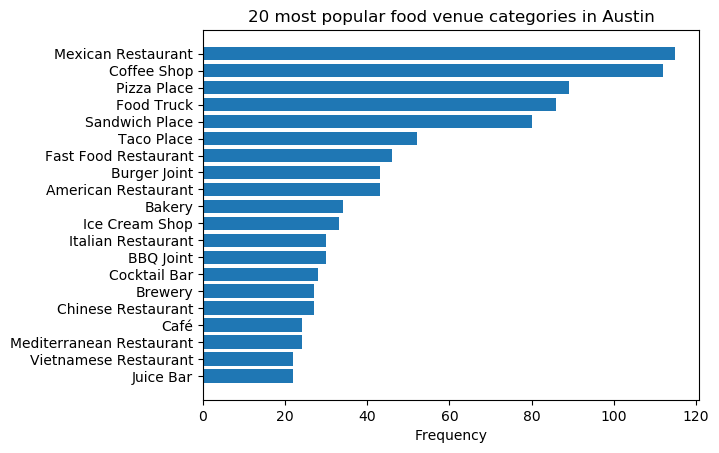

In [996]:
fig, ax = plt.subplots()

# Example data
venues = austin_food_places.columns.values[1:21]
y_pos = np.arange(len(venues))
frequency = austin_food_places.T['Sum'].values[1:21]

ax.barh(y_pos, frequency, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(venues)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('20 most popular food venue categories in Austin')

plt.show()

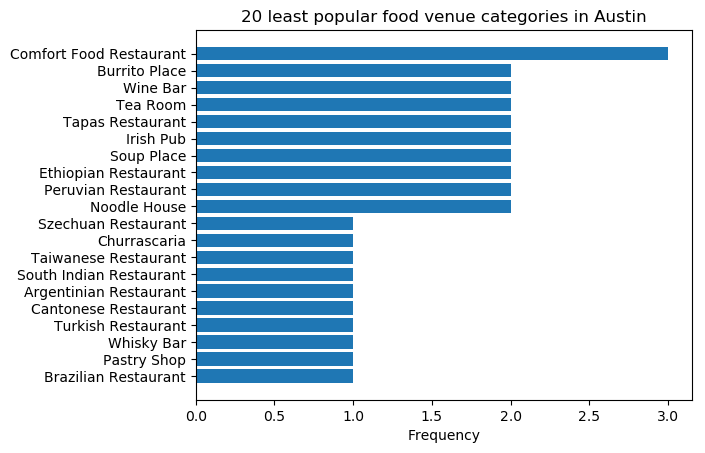

In [997]:
fig, ax = plt.subplots()

# Example data
venues = austin_food_places.columns.values[-20:]
y_pos = np.arange(len(venues))
frequency = austin_food_places.T['Sum'].values[-20:]

ax.barh(y_pos, frequency, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(venues)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('20 least popular food venue categories in Austin')

plt.show()

Let's store the bottom 20 venues separately. This new dataframe contains the most important information for us, since we would like to analyse the data and suggest where to open an unusual restaurant.

In [1002]:
bottom_20 = austin_venues[austin_venues['Venue Category'].isin(venues)]

In order to decide what type of restaurant to open, we further obtain the rating and likes data for the venues in our list.

In [1044]:
rating_list=[]
likes_list =[]
likes_list =[]
for id in bottom_20['Venue ID']:
    print(id)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        id, CLIENT_ID,
        CLIENT_SECRET, VERSION)

    # make the GET request
    result = requests.get(url).json()
    try:
        rating_list.append(result['response']['venue']['rating'])
    except:
        rating_list.append(-1)
    try:
        likes_list.append(result['response']['venue']['likes']['count'])
    except:
        likes_list.append(0)

4388f700f964a520152b1fe3
4a077e41f964a5206e731fe3
593c96849ec3995c0c49fbc5
4adf782cf964a520e07a21e3
4ba8f8bdf964a52031ff39e3
4ae7657cf964a520f0aa21e3
5261db9511d2b9ed254233d6
52169f0711d26dd8be94f30a
4ff0f46a011c9ad2fa340562
59b2ff121499466c7a7a23c2
519523f1498ec02c62bb194a
4cfa65e920fe370484024df8
53f41155498e988806aab96a
56e8b198498ecb451961689f
4aceefb7f964a52013d220e3
59dea6d04c9be64e04acfbc5
525d8fa5498e73e322f6ebe0
58c72da78ab03f1ed5f9277e
525d8fa5498e73e322f6ebe0
5436c7d8498ed356390d3808
55a151cd498e3ac2446b1e37
4f348c3f7bebf16206886b93
4ba40aa1f964a520d77a38e3
49bed457f964a520e5541fe3
56a121e6498e5b081d165b36
4d8cbe27d00a6ea8e168914f
50f04fa4e4b002d1a54c892b
4b632f82f964a52002692ae3
5468ecfe498e87b191079be1
4ea73125b8f7ff211a5ef903
49e71bedf964a52079641fe3


We add the new information into our dataframe.

In [1045]:
bottom_20['Rating'] = rating_list.copy()
bottom_20['Likes'] = likes_list.copy()
bottom_20

/Users/iambartsumyan/anaconda3/envs/qf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/iambartsumyan/anaconda3/envs/qf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Likes
54,"2nd Street Disrict, Arts District, Brush Park,...",30.2720,-97.7420,BD Riley's Irish Pub,4388f700f964a520152b1fe3,30.267729,-97.741167,Irish Pub,7.6,177
120,"6th Street Disrict, 6th Street District, Conve...",30.2695,-97.7280,"Buenos Aires Cafe, Este",4a077e41f964a5206e731fe3,30.264282,-97.730381,Argentinian Restaurant,8.1,97
156,"6th Street Disrict, 6th Street District, Conve...",30.2695,-97.7280,Seven Grand,593c96849ec3995c0c49fbc5,30.267673,-97.738554,Whisky Bar,8.6,23
208,"UT, University of Texas (UT)",30.2820,-97.7380,CoCo's Cafe,4adf782cf964a520e07a21e3,30.282542,-97.742263,Taiwanese Restaurant,7.7,70
220,"UT, University of Texas (UT)",30.2820,-97.7380,Burrito Factory,4ba8f8bdf964a52031ff39e3,30.283444,-97.741322,Burrito Place,7.4,11
385,East Austin,30.2700,-97.7000,Zhi Tea,4ae7657cf964a520f0aa21e3,30.261206,-97.697858,Tea Room,8.5,26
575,"Bryker Woods, Old Enfield, Windsor Road",30.2930,-97.7490,Cabo Bob's,5261db9511d2b9ed254233d6,30.295861,-97.744015,Burrito Place,8.8,104
678,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Winebelly,52169f0711d26dd8be94f30a,30.241435,-97.758936,Tapas Restaurant,8.8,99
687,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Soup Peddler Real Food & Juice Bar,4ff0f46a011c9ad2fa340562,30.246298,-97.756045,Soup Place,8.7,69
691,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Phoebe's Diner,59b2ff121499466c7a7a23c2,30.241796,-97.759221,Comfort Food Restaurant,8.0,25


Let's save the resulting dataframes.

In [1046]:
bottom_20.to_csv("bottom_20.csv", sep='\t')
austin_food_places.to_csv("austin_food_places.csv", sep='\t')
austin_onehot.to_csv("austin_onehot.csv", sep='\t')

Here is the list of the most unusual restaurants in Austin, sorted by rating.

In [1054]:
bottom_20.sort_values(by = ['Rating'], axis=0, ascending=False,inplace=True)
bottom_20.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Likes
678,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.763,Winebelly,52169f0711d26dd8be94f30a,30.241435,-97.758936,Tapas Restaurant,8.8,99
575,"Bryker Woods, Old Enfield, Windsor Road",30.2930,-97.749,Cabo Bob's,5261db9511d2b9ed254233d6,30.295861,-97.744015,Burrito Place,8.8,104
687,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.763,Soup Peddler Real Food & Juice Bar,4ff0f46a011c9ad2fa340562,30.246298,-97.756045,Soup Place,8.7,69
819,South Austin (Austin del Sur),30.2075,-97.820,Sichuan River,53f41155498e988806aab96a,30.230921,-97.802418,Szechuan Restaurant,8.7,31
156,"6th Street Disrict, 6th Street District, Conve...",30.2695,-97.728,Seven Grand,593c96849ec3995c0c49fbc5,30.267673,-97.738554,Whisky Bar,8.6,23


Let's focus on the best options, i.e., the venues with rating higher than 8.0 and at least 50 likes.

In [1058]:
candidates = bottom_20[bottom_20_copy['Rating']>=8.0]
candidates = candidates[candidates['Likes']>=50]
candidates

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Likes
678,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Winebelly,52169f0711d26dd8be94f30a,30.241435,-97.758936,Tapas Restaurant,8.8,99
575,"Bryker Woods, Old Enfield, Windsor Road",30.2930,-97.7490,Cabo Bob's,5261db9511d2b9ed254233d6,30.295861,-97.744015,Burrito Place,8.8,104
687,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Soup Peddler Real Food & Juice Bar,4ff0f46a011c9ad2fa340562,30.246298,-97.756045,Soup Place,8.7,69
2830,North Burnet,30.3925,-97.7355,Cru Wine Bar,49e71bedf964a52079641fe3,30.401997,-97.726415,Wine Bar,8.6,70
2445,"Georgian Acres, Heritage Hills, North Lamar, W...",30.3710,-97.6720,New Fortune Chinese Seafood Restaurant,5468ecfe498e87b191079be1,30.377848,-97.688096,Cantonese Restaurant,8.6,78
2238,"Hyde Park, North Loop, Triangle State",30.3080,-97.7250,Vino Vino,49bed457f964a520e5541fe3,30.306973,-97.735281,Wine Bar,8.4,95
1916,Southeast Austin (SE Austin),30.1575,-97.7500,Teapioca Lounge,4f348c3f7bebf16206886b93,30.160661,-97.791289,Tea Room,8.3,54
719,"Auditorium Shores, Barton Springs, Bouldin Cre...",30.2440,-97.7630,Barlata,519523f1498ec02c62bb194a,30.252468,-97.764229,Tapas Restaurant,8.3,118
1269,Upper Boggy Creek,30.2960,-97.6990,Xian Sushi & Noodle,525d8fa5498e73e322f6ebe0,30.302841,-97.699082,Noodle House,8.1,86
1310,"Oriens Park, Pecan Springs-springdale, Rmma, U...",30.3070,-97.6830,Xian Sushi & Noodle,525d8fa5498e73e322f6ebe0,30.302841,-97.699082,Noodle House,8.1,86


We see that among the final list are two Tapas Restaurant, two Wine Bars, two Noodle Houses (although these are the same venues with two different locations). Moreover, one of Tapas Restaurants has the highest rating, and another one - second to largest number of likes. Based on the demographics of the city, we therefore decide to choose __Tapas Restaurant__ as the most preferable category. We present a more detailed motivation in the report and presentation. 

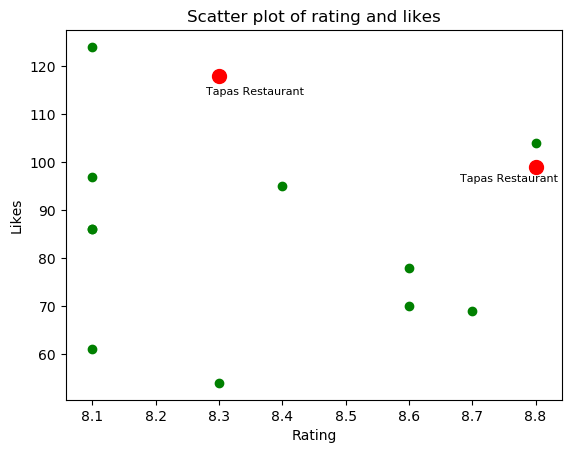

In [1079]:
plt.scatter(candidates['Rating'], candidates['Likes'], color= 'green')
plt.title('Scatter plot of rating and likes')
plt.xlabel('Rating')
plt.ylabel('Likes')
plt.text(8.28, 114, 'Tapas Restaurant', fontsize=8)
plt.text(8.68, 96, 'Tapas Restaurant', fontsize=8)
plt.plot(8.8,99, marker = 'o', markersize=10, color='red')
plt.plot(8.3,118, marker = 'o', markersize=10, color='red')
plt.show()

## 4. Cluster analysis of the neighborhoods

Lastly, we need to decide which neighborhood is the most attractive one to open a Tapas Restaurant. To answer this question, we cluster the neighborhods and analyze the cluster that conatins the neighborhood with two Tapas Restaurants.

In [1259]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We proceed with similar analysis, as the one performed in the labs. The only difference is that we keep the area and population as features.

In [1497]:
austin_grouped = austin_onehot_init.groupby('Neighborhood').mean()
austin_grouped.reset_index(inplace=True)
austin_grouped.head()
popul = []
ar = []
for val in austin_grouped['Neighborhood']:
    popul.append(neighborhoods_data[neighborhoods_data['Neighborhood']==val]['Population'].values[0])
    ar.append(neighborhoods_data[neighborhoods_data['Neighborhood']==val]['Area'].values[0])
austin_grouped.drop(columns=['Population','Area'], inplace=True)
austin_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfall,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"2nd Street Disrict, Arts District, Brush Park,...",0.0,0.013514,0.0,0.000000,0.0,0.0,0.00,0.000000,0.013514,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000
1,"6th Street Disrict, 6th Street District, Conve...",0.0,0.000000,0.0,0.030000,0.0,0.0,0.01,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.030000
2,"Alamo Park, Blackland (Rogers-Washington-Holy ...",0.0,0.000000,0.0,0.046512,0.0,0.0,0.00,0.023256,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000
3,"Allandale, Rosedale",0.0,0.000000,0.0,0.014925,0.0,0.0,0.00,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.014925
4,"Auditorium Shores, Barton Springs, Bouldin Cre...",0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.010000,0.000000,...,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.010000


In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = austin_grouped['Neighborhood']

for ind in np.arange(austin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted['Population'] = popul
neighborhoods_venues_sorted['Area'] = ar       

We split the neighborhoods into 7 clusters.

In [1511]:
from sklearn.preprocessing import StandardScaler
# set number of clusters
kclusters = 7
austin_grouped_clustering = austin_grouped.drop('Neighborhood',1)
austin_grouped['Population'] = popul
austin_grouped['Area'] = ar
scaler = StandardScaler()
austin_grouped_clustering[austin_grouped_clustering.columns] = scaler.fit_transform(
    austin_grouped_clustering[austin_grouped_clustering.columns])
# austin_grouped_clustering = austin_grouped_clustering.drop('Area',1)
# austin_grouped_clustering = austin_grouped_clustering.drop('Population',1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

/Users/iambartsumyan/anaconda3/envs/qf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/iambartsumyan/anaconda3/envs/qf/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([1, 6, 3, 1, 2, 1, 1, 3, 1, 1, 4, 3, 6, 3, 1, 1, 1, 3, 1, 1, 6, 1,
       1, 3, 1, 1, 1, 4, 2, 3, 1, 1, 1, 1, 2, 1, 0, 3, 1, 1, 1, 3, 1, 1,
       4, 3, 5], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
austin_merged = neighborhoods_data.loc[neighborhoods_data['Neighborhood'].isin(austin_venues['Neighborhood'].unique())]

# merge austin_grouped with austin_data to add latitude/longitude for each neighborhood
austin_merged = austin_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood') 

Let's visualize the results of the clustering procedure.

In [1505]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
address = 'Austin, TX'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'], 
                                  austin_merged['Longitude'], 
                                  austin_merged['Neighborhood'],
                                  austin_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' 
                         + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

Finally, we extract the neighborhoods in the cluster that contains the neighborhood Tapas Restaurants.

In [1509]:
austin_merged.loc[austin_merged['Cluster Labels'] == 2, 
                  austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]['Neighborhood']



9     Auditorium Shores, Barton Springs, Bouldin Cre...
36                Hyde Park, North Loop, Triangle State
45                                         North Burnet
Name: Neighborhood, dtype: object

We are now ready to choose the neighborhood optimal to open a new Tapas Restaurant. As we see, there are three options. The first neigborhood (index 9) already has 2 Tapas Places, so it is probably better to pick another neighborhood for a new one. __Hence, we conclude that if one would like to open a new place, they should focus on one of the following:__
- Hyde Park
- North Loop
- Triangle State
- North Burnet

We also note that there are __Wine Bars__ in both neighborhood 36 (Hyde Park, North Loop, Triangle State) and neighborhoods 45 (North Burnet). This seems to be a good sign, since this category is similar to Tapas Restaurant, so a new Tapas Restaurant should fit nicely in such a neighborhood.

# Results and Discussion <a name="results"></a>

We performed the analysis of Austin's neighborhoods and available restaurant. According to the data, the most popular venue types include Mexican Restaurants, Cofee Shops, Pizza Restaurants and other, while the places such as Tapas Restaurants, Wine Bars, and exotic cuisines, such as Ethiopian and Peruvian, are not very common. 

Based on the amount of likes and rating of such unusual places, we concluded that the best option is to open a new __Tapas Restaurant__. In order to avoid unnecessary competitions, we further performed clustering analysis of the neighborhoods of Austin in order to pick the best location with now Tapas Restaurants available at the moment, but at the same time similar to the neighborhoods that do have such restaurants. We concluded that one of the following would be the optimal:
- Hyde Park
- North Loop
- Triangle State
- North Burnet

We noticed, that the results look reasonable, as the the neighborhoods that we picked have similar venue categories, so a new Tapas Restaurant should be interesting for the residents. Also, from the personal experience, these neighborhoods are growing and attract relatively young people with middle to high income, so a Tapas Restaurant should indeed be a good choice.

We note that the performed analysis has two weaknesses:
- The neighborhoods were represented as circles, based on the area, and the radius of each circle (with some adjustments) was used to the Foursquare calls. Clearly, such assumption doesn't sound very realistic, as the neighborhoods can be irregularly shaped. However, a more accurate procedure seems to be unavailable, since Foursquare calls use geographical coordinates of the center of a neighborhood and a radius.
- The neighborhoods sharing same zipcode were combined into bigger ones and the corresponding coordinated were computed as the average values. Although, this might be innacurate and introduce some errors into the analysis, a more accurate geographical segmentation of the city is out of the scope of this project.